In [1]:
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from gensim.models import LdaModel, CoherenceModel
from gensim.corpora import Dictionary
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from gensim import corpora, models
from pprint import pprint

In [2]:
# Download the VADER lexicon
nltk.download('vader_lexicon')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')


[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/priyakundu/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/priyakundu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/priyakundu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/priyakundu/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/priyakundu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

##### Performing Sentiment Analysis

In [3]:
# Create a DataFrame
df = pd.read_csv("British_Airways_reviews.csv")

# Function to clean text and extract verification status
def clean_text_and_extract_verification(text):
    # Extracting verification status
    verification_status = "Trip Verified" if "Trip Verified" in text else "Not Verified"
    
    # Cleaning text (remove non-alphanumeric characters and verification status)
    cleaned_text = ''.join(e for e in text if e.isalnum() or e.isspace())
    cleaned_text = cleaned_text.replace(verification_status, '')
    
    return verification_status, cleaned_text

# Apply text cleaning and extract verification status
df['verification_status'], df['clean_reviews'] = zip(*df['reviews'].apply(clean_text_and_extract_verification))

# Function for sentiment analysis
def analyze_sentiment(text):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(text)['compound']
    return 'positive' if sentiment_score >= 0 else 'negative'

# Apply sentiment analysis to the 'clean_reviews' column
df['sentiment'] = df['clean_reviews'].apply(analyze_sentiment)

df.drop(['reviews', 'Unnamed: 0'], axis=1, inplace=True)
df

,verification_status,clean_reviews,sentiment
0,Trip Verified,The plane was extremely dirty with chocola...,negative
1,Not Verified,Overall journey wasnt bad however at the end...,negative
2,Trip Verified,Overall very satisfied Ground staff member...,positive
3,Trip Verified,As always when I fly BA it was a total sha...,negative
4,Trip Verified,First time using BA business class but we ...,positive
...,...,...,...
995,Trip Verified,London to Chennai It was amazing The crew ...,positive
996,Not Verified,London to Tampa BA broke my suitcase and I ...,negative
997,Trip Verified,My husband and I flew on British Airways f...,negative
998,Trip Verified,Bridgetown to Gatwick I couldnt imagine th...,negative


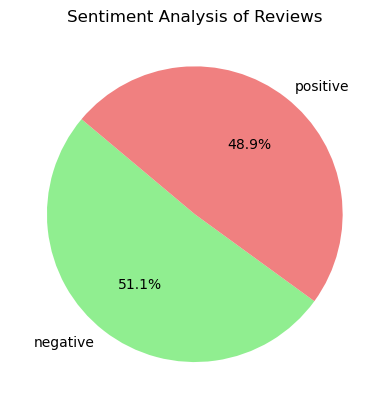

In [4]:
# Pie chart
sentiment_counts = df['sentiment'].value_counts()
labels = sentiment_counts.index
sizes = sentiment_counts.values

plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=140, colors=['lightgreen', 'lightcoral'])
plt.title('Sentiment Analysis of Reviews')
plt.show()

##### Performing Topic Modeling

In [5]:
# Preprocess and clean the text
stop_words = set(stopwords.words('english'))
custom_stopwords = set(['a', 'an', 'the', 'in', 'on', 'at', 'to', 'for', 'with', 'by', 'of', 'and', 'but', 'or', 'nor', 'so', 'yet'])

def preprocess_text(text):
    tokens = word_tokenize(text.lower())  # Tokenization and lowercase
    filtered_tokens = [word for word in tokens if word.isalpha() and word not in stop_words.union(custom_stopwords)]
    return filtered_tokens

# Apply preprocessing to all reviews
processed_reviews = [preprocess_text(review) for review in df["clean_reviews"]]

# Create a dictionary representation of the documents
dictionary = corpora.Dictionary(processed_reviews)

# Convert the dictionary to a bag-of-words representation
corpus = [dictionary.doc2bow(review) for review in processed_reviews]

# Train the LDA (Latent Dirichlet Allocation) model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print the topics and associated words
topics = lda_model.print_topics(num_words=15)
for topic in topics:
    print(topic)

(0, '0.016*"flight" + 0.012*"seat" + 0.010*"bag" + 0.005*"food" + 0.005*"back" + 0.004*"premium" + 0.004*"cabin" + 0.004*"london" + 0.004*"boarding" + 0.004*"never" + 0.004*"hour" + 0.004*"would" + 0.004*"luggage" + 0.004*"drink" + 0.004*"gate"')
(1, '0.022*"flight" + 0.013*"ba" + 0.013*"london" + 0.010*"luggage" + 0.008*"us" + 0.006*"airways" + 0.006*"airport" + 0.005*"said" + 0.005*"british" + 0.004*"could" + 0.004*"lounge" + 0.004*"service" + 0.004*"heathrow" + 0.004*"gave" + 0.004*"terminal"')
(2, '0.009*"heathrow" + 0.009*"ba" + 0.005*"one" + 0.005*"help" + 0.004*"service" + 0.004*"another" + 0.004*"said" + 0.004*"london" + 0.003*"class" + 0.003*"british" + 0.003*"met" + 0.003*"crew" + 0.003*"holiday" + 0.003*"business" + 0.003*"flew"')
(3, '0.032*"flight" + 0.018*"ba" + 0.008*"service" + 0.008*"us" + 0.008*"hours" + 0.008*"british" + 0.008*"airways" + 0.008*"get" + 0.007*"would" + 0.007*"customer" + 0.006*"told" + 0.006*"london" + 0.006*"cancelled" + 0.006*"time" + 0.006*"airport

In [11]:
# Function to compute coherence score for a model and corpus
def compute_coherence_score(model, corpus, dictionary, texts):
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Compute coherence scores for different numbers of topics
coherence_scores = []
for num_topics in range(1, 21):  # Try different numbers of topics
    lda_model = models.LdaModel(corpus, num_topics=num_topics, id2word=dictionary, passes=15)
    coherence_score = compute_coherence_score(lda_model, corpus, dictionary, processed_reviews)
    coherence_scores.append((num_topics, coherence_score))

# # Choose the number of topics with the highest coherence score
# optimal_num_topics = max(coherence_scores, key=lambda x: x[1])[0]

# Train the LDA model with the optimal number of topics
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print the topics and associated words
topics = lda_model.print_topics(num_words=15)
for topic in topics:
    print(topic)


(0, '0.010*"london" + 0.010*"one" + 0.008*"time" + 0.008*"staff" + 0.007*"passengers" + 0.006*"bag" + 0.006*"cabin" + 0.005*"seats" + 0.005*"boarding" + 0.005*"hours" + 0.005*"luggage" + 0.005*"even" + 0.005*"last" + 0.005*"delayed" + 0.004*"crew"')
(1, '0.006*"seats" + 0.006*"london" + 0.005*"even" + 0.005*"offered" + 0.005*"airline" + 0.005*"time" + 0.005*"business" + 0.004*"one" + 0.004*"attendant" + 0.004*"seat" + 0.004*"back" + 0.004*"cancelled" + 0.003*"take" + 0.003*"pillow" + 0.003*"class"')
(2, '0.027*"good" + 0.015*"food" + 0.013*"seat" + 0.013*"class" + 0.011*"crew" + 0.011*"service" + 0.011*"business" + 0.010*"time" + 0.009*"club" + 0.009*"lounge" + 0.009*"seats" + 0.009*"cabin" + 0.007*"first" + 0.007*"london" + 0.006*"boarding"')
(3, '0.009*"service" + 0.009*"us" + 0.008*"get" + 0.008*"would" + 0.008*"customer" + 0.008*"told" + 0.007*"hours" + 0.007*"british" + 0.007*"airways" + 0.007*"london" + 0.006*"one" + 0.006*"airport" + 0.006*"booked" + 0.005*"cancelled" + 0.005*"c

In [8]:
# Function to preprocess the text
def preprocess_text(text):
    # Tokenize the text
    tokens = word_tokenize(text)
    
    # Remove stopwords, prepositions, articles, and conjunction words
    stop_words = set(stopwords.words('english'))
    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    
    return filtered_tokens

# Preprocess the reviews
df['Processed_Review'] = df['clean_reviews'].apply(preprocess_text)
df

,verification_status,clean_reviews,sentiment,Processed_Review
0,Trip Verified,The plane was extremely dirty with chocola...,negative,"[plane, extremely, dirty, chocolate, smudged, ..."
1,Not Verified,Overall journey wasnt bad however at the end...,negative,"[overall, journey, wasnt, bad, however, end, b..."
2,Trip Verified,Overall very satisfied Ground staff member...,positive,"[overall, satisfied, ground, staff, member, yv..."
3,Trip Verified,As always when I fly BA it was a total sha...,negative,"[always, fly, ba, total, shambles, booked, man..."
4,Trip Verified,First time using BA business class but we ...,positive,"[first, time, using, ba, business, class, plea..."
...,...,...,...,...
995,Trip Verified,London to Chennai It was amazing The crew ...,positive,"[london, chennai, amazing, crew, friendly, foo..."
996,Not Verified,London to Tampa BA broke my suitcase and I ...,negative,"[london, tampa, ba, broke, suitcase, make, fus..."
997,Trip Verified,My husband and I flew on British Airways f...,negative,"[husband, flew, british, airways, flight, balt..."
998,Trip Verified,Bridgetown to Gatwick I couldnt imagine th...,negative,"[bridgetown, gatwick, couldnt, imagine, first,..."


In [9]:
# Function to preprocess text
def preprocess_text(tokens):
    stop_words = set(stopwords.words('english'))
    custom_stop_words = set(['flight', 'ba'])  # Custom stop words
    stop_words = stop_words.union(custom_stop_words)

    filtered_tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]

    return filtered_tokens

# Apply preprocessing to each row in the "Processed_Review" column
df['Processed_Review'] = df['Processed_Review'].apply(preprocess_text)

# Create a dictionary representation of the documents.
dictionary = corpora.Dictionary(df['Processed_Review'])

# Create a corpus from a list of texts
corpus = [dictionary.doc2bow(review) for review in df['Processed_Review']]

# Train the LDA model
lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=15)

# Print topics for positive reviews
positive_reviews = df[df['sentiment'] == 'positive']
positive_corpus = [dictionary.doc2bow(review) for review in positive_reviews['Processed_Review']]
positive_topics = lda_model.show_topics(num_topics=10, num_words=5)

print("Top 10 Positive Review Topics:")
pprint(positive_topics)

# Train a new LDA model for negative reviews
negative_reviews = df[df['sentiment'] == 'negative']
negative_corpus = [dictionary.doc2bow(review) for review in negative_reviews['Processed_Review']]
negative_lda_model = models.LdaModel(negative_corpus, num_topics=10, id2word=dictionary, passes=15)

# Print topics for negative reviews
negative_topics = negative_lda_model.show_topics(num_topics=10, num_words=5)
print("\nTop 10 Negative Review Topics:")
pprint(negative_topics)

Top 10 Positive Review Topics:
[(0,
  '0.010*"seats" + 0.009*"business" + 0.009*"seat" + 0.008*"would" + '
  '0.008*"class"'),
 (1,
  '0.012*"good" + 0.011*"class" + 0.010*"business" + 0.010*"london" + '
  '0.010*"food"'),
 (2,
  '0.013*"service" + 0.008*"british" + 0.008*"airways" + 0.008*"cabin" + '
  '0.007*"crew"'),
 (3,
  '0.015*"crew" + 0.009*"food" + 0.008*"class" + 0.008*"cabin" + 0.008*"seat"'),
 (4,
  '0.012*"customer" + 0.011*"british" + 0.011*"service" + 0.011*"airways" + '
  '0.009*"told"'),
 (5,
  '0.021*"good" + 0.014*"food" + 0.012*"seats" + 0.012*"time" + 0.011*"seat"'),
 (6,
  '0.011*"crew" + 0.009*"london" + 0.009*"cabin" + 0.009*"service" + '
  '0.008*"time"'),
 (7,
  '0.011*"good" + 0.009*"seat" + 0.008*"time" + 0.007*"hours" + 0.006*"food"'),
 (8,
  '0.014*"service" + 0.008*"class" + 0.008*"business" + 0.008*"one" + '
  '0.007*"airline"'),
 (9,
  '0.009*"airport" + 0.007*"one" + 0.006*"staff" + 0.006*"us" + 0.005*"hours"')]

Top 10 Negative Review Topics:
[(0,
  '

In [10]:
# Function to compute coherence score for a model and corpus
def compute_coherence_score(model, corpus, dictionary, texts):
    coherence_model = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherence_model.get_coherence()

# Sort topics based on coherence score for positive reviews
positive_coherence_scores = [(i, compute_coherence_score(lda_model, positive_corpus, dictionary, positive_reviews['Processed_Review'])) for i in range(10)]
sorted_positive_topics = sorted(positive_coherence_scores, key=lambda x: x[1], reverse=True)
sorted_positive_topics = [(topic[0], lda_model.show_topic(topic[0])) for topic in sorted_positive_topics]

# Sort topics based on coherence score for negative reviews
negative_coherence_scores = [(i, compute_coherence_score(negative_lda_model, negative_corpus, dictionary, negative_reviews['Processed_Review'])) for i in range(10)]
sorted_negative_topics = sorted(negative_coherence_scores, key=lambda x: x[1], reverse=True)
sorted_negative_topics = [(topic[0], negative_lda_model.show_topic(topic[0])) for topic in sorted_negative_topics]

# Print sorted topics
print("Top 10 Positive Review Topics (Sorted by Coherence Score):")
pprint(sorted_positive_topics)

print("\nTop 10 Negative Review Topics (Sorted by Coherence Score):")
pprint(sorted_negative_topics)

Top 10 Positive Review Topics (Sorted by Coherence Score):
[(0,
  [('seats', 0.010179671),
   ('business', 0.009163428),
   ('seat', 0.009099809),
   ('would', 0.0077808197),
   ('class', 0.0077601583),
   ('heathrow', 0.007310415),
   ('london', 0.0072184503),
   ('hours', 0.006572258),
   ('could', 0.005442292),
   ('back', 0.005257181)]),
 (1,
  [('good', 0.011796015),
   ('class', 0.010948113),
   ('business', 0.010429824),
   ('london', 0.009835523),
   ('food', 0.009505274),
   ('service', 0.0072079925),
   ('time', 0.0072067417),
   ('crew', 0.007080526),
   ('one', 0.0065993853),
   ('first', 0.0065045957)]),
 (2,
  [('service', 0.012694709),
   ('british', 0.00782765),
   ('airways', 0.007595991),
   ('cabin', 0.0075488766),
   ('crew', 0.0070067006),
   ('london', 0.006952795),
   ('time', 0.006736786),
   ('food', 0.0062409695),
   ('get', 0.006092503),
   ('bag', 0.005999843)]),
 (3,
  [('crew', 0.015234848),
   ('food', 0.009374676),
   ('class', 0.008449511),
   ('cabin',

In [13]:
# Function to convert sorted topics to DataFrame
def sorted_topics_to_dataframe(sorted_topics, category):
    data = {'Topic': [], 'Top Words and Probabilities': []}
    for topic_num, words_prob in sorted_topics:
        topic_label = f'Topic {topic_num}'
        top_words_probabilities = ', '.join([f'{word} ({prob:.6f})' for word, prob in words_prob])
        data['Topic'].append(topic_label)
        data['Top Words and Probabilities'].append(top_words_probabilities)
    return pd.DataFrame(data)

# Convert sorted positive topics to DataFrame
positive_df = sorted_topics_to_dataframe(sorted_positive_topics, 'Positive')

# Convert sorted negative topics to DataFrame
negative_df = sorted_topics_to_dataframe(sorted_negative_topics, 'Negative')

# Save DataFrames to CSV files
positive_df.to_csv('sorted_positive_topics.csv', index=False, encoding='utf-8')
negative_df.to_csv('sorted_negative_topics.csv', index=False, encoding='utf-8')

In [14]:
# Function to convert sorted topics to DataFrame
def sorted_topics_to_dataframe(sorted_topics, category):
    data = {'Topic': [], 'Top Words and Probabilities': []}
    for topic_num, words_prob in sorted_topics:
        topic_label = f'Topic {topic_num}'
        top_words_probabilities = ', '.join([f'{word} ({prob:.6f})' for word, prob in words_prob])
        data['Topic'].append(topic_label)
        data['Top Words and Probabilities'].append(top_words_probabilities)
    return pd.DataFrame(data)

# Convert sorted positive topics to DataFrame
positive_df = sorted_topics_to_dataframe(sorted_positive_topics, 'Positive')

# Convert sorted negative topics to DataFrame
negative_df = sorted_topics_to_dataframe(sorted_negative_topics, 'Negative')



In [15]:
positive_df

,Topic,Top Words and Probabilities
0,Topic 0,"seats (0.010180), business (0.009163), seat (0..."
1,Topic 1,"good (0.011796), class (0.010948), business (0..."
2,Topic 2,"service (0.012695), british (0.007828), airway..."
3,Topic 3,"crew (0.015235), food (0.009375), class (0.008..."
4,Topic 4,"customer (0.012476), british (0.011260), servi..."
5,Topic 5,"good (0.021425), food (0.013632), seats (0.011..."
6,Topic 6,"crew (0.011121), london (0.009474), cabin (0.0..."
7,Topic 7,"good (0.011162), seat (0.009292), time (0.0083..."
8,Topic 8,"service (0.013585), class (0.008211), business..."
9,Topic 9,"airport (0.009476), one (0.006599), staff (0.0..."


In [16]:
negative_df

,Topic,Top Words and Probabilities
0,Topic 0,"london (0.006923), crew (0.005250), hours (0.0..."
1,Topic 1,"service (0.013841), seat (0.009914), class (0...."
2,Topic 2,"service (0.011332), british (0.009464), airway..."
3,Topic 3,"us (0.010352), hours (0.006411), one (0.006219..."
4,Topic 4,"class (0.014262), business (0.010223), seats (..."
5,Topic 5,"business (0.015256), class (0.014156), seats (..."
6,Topic 6,"service (0.013371), one (0.009054), staff (0.0..."
7,Topic 7,"us (0.011945), hours (0.010263), get (0.009468..."
8,Topic 8,"london (0.008595), arrived (0.007598), custome..."
9,Topic 9,"crew (0.009651), seat (0.008448), one (0.00779..."
